<h1><center>Marketing Security Services for the Asheville, NC</center></h1>

<h3><center>Greg Waitt</center></h3>

<h3><center>March 29, 2021</center></h3>

### Problem

A security firm in Asheville, NC is wanting to expand their business.  They currently offer security system monitoring and in person security patrols.  They have a limited budget for expansion and need to identify potential new clients with a focused process.  They are also interested in potential new services that they could add to their business.  The security firm has no expertise on how to do this, so they hire a marketing group that uses data science to guide their recommendations.

### Background

Asheville, NC can be broken down into several neighborhoods.  Some of these are residential and some are business.  The business neighborhoods have a variety of business that range from offices to bars and restaurants.  Most businesses have some type of security system.  Alarms, cameras, night security and full-time security guards are examples.  As in all cities some areas are more prone to crime than others.  The higher crime areas are in greater need for security than the lower crime areas.  Crime and business data will be combined and compared to create targeted marketing materials for security services. 

### Data

Data specific to Asheville, NC will be pulled from https://data-avl.opendata.arcgis.com/.  The website has API access to many diverse data sets about the city.  Neighborhood information will be extracted to identify each neighborhood name and their location in the city.  The downloaded data already has latitude and longitude for each neighborhood boundary.  The center point of the boundary coordinates will be used as the neighborhood location.  Data for arrests will be also be extracted.  The arrest data contains the street address, type of crime, and the date (along with many other details). A python client, geopy, will be used to identify the coordinates of the address for each arrest.  The location data will be added to the arrest data.  The data will be reduced to by date to include only arrests in the past year.  This crime data will be combined with the arrest data to identify a neighborhood for each crime.  

The Foursquare API, from https://developer.foursquare.com/ will be used to extract business/venue information for the neighborhoods in Asheville.  The arrest data and venue data will be clustered individually and combined to identify businesses in areas where certain crimes and business are clustered together.  Marketing materials can then be designed specifically for the type of business and crimes that are committed in the same area.  For example, if a neighborhood has a cluster of bars and restaurants with arrests of disorderly conduct then onsite security services could be recommended.  If a cluster of trespassing and retails might only need security monitoring.  The data will also be gleaned for new business opportunities by searching for untapped business/crime combinations.   


### Exploratory Analysis

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [55]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


#### Neighborhood Data

Download the neighborhood data from:  https://data-avl.opendata.arcgis.com/

In [ ]:
url_hood = "https://opendata.arcgis.com/datasets/4886b22454344aefb4ef0a4a5e591c01_0.geojson"
json_data_hood = requests.get(url_hood)
type(json_data_hood)

Examine the json file for key features

In [ ]:
json_data_hood.json()['features']

In [ ]:
feature_data_hood = json_data_hood.json()['features']
len(feature_data_hood)

Build data frame from neighborhood json file

In [ ]:
hood_df = pd.DataFrame(columns = ['status', 'name', 'latitude', 'longitude'])
for i in range(len(feature_data_hood)):
    temp =feature_data_hood[i]['geometry']['coordinates']
    flat_list = [item for sublist in temp for item in sublist]
    temp_df = pd.DataFrame(flat_list, columns = ("longitude", "latitude"))
    hood_df = hood_df.append({'status': feature_data_hood[i]['properties']['status'],
                                 'name': feature_data_hood[i]['properties']['name'],
                                 'latitude': (temp_df['latitude'].max() + temp_df['latitude'].min())/2,
                                 'longitude': (temp_df['longitude'].max() + temp_df['longitude'].min())/2}, ignore_index=True)  
len(hood_df)

In [416]:
hood_df.head()

,status,name,latitude,longitude
0,Active,Wilshire Park,35.586182,-82.605537
1,Active,Cimarron,35.530022,-82.520192
2,Active,Redwood Forest,35.582871,-82.515243
3,Active,Cloister Condominiums,35.579717,-82.506536
4,Active,Lake View Park,35.636972,-82.561621


Include only "active" neighborhoods

In [414]:
hood_df = hood_df[hood_df['status'] == 'Active']
print("There are {} neighborhoods in Asheville".format(len(hood_df)))

There are 58 neighborhoods in Asheville


save neigihborhood file to csv, no need to go through these steps every time

In [ ]:
hood_df.to_csv("hood_df.csv", index=False)

load hood_df.csv if needed

In [ ]:
#hood_df = pd.read_csv("hood_df.csv")

Let's map the neighborhoods to see how they lay out

In [415]:
address = 'Asheville, NC'

geolocator = Nominatim(user_agent="asheville_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Asheville are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Asheville are 35.6009498, -82.5540161.


In [418]:
# Creating the map of Asheville, NC
map_Asheville = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for latitude, longitude, neighborhood in zip(hood_df['latitude'], hood_df['longitude'], hood_df['name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True
        ).add_to(map_Asheville)  
    
map_Asheville

#### Arrest Data

Download the neighborhood data from: https://data-avl.opendata.arcgis.com/

In [3]:
url_arrest = "https://opendata.arcgis.com/datasets/38bdfa06548a45bc9c89c7dddcfc5f31_0.geojson"
json_data_arrest = requests.get(url_arrest)
type(json_data_arrest)

Examine the json file for key features

In [5]:
json_data_arrest.json()['features']

[{'type': 'Feature',
  'properties': {'OBJECTID': 1,
   'date_arrested': '2012-01-01',
   'time_arrested': '0000',
   'address': '100-BLK BARTLETT ST',
   'offense_type': 'SECOND DEGREE TRESPASS                                      ',
   'subject_race': 'B',
   'subject_gender': 'F',
   'agency': 'APD',
   'armainid': 425023,
   'objectid_1': 1},
  'geometry': None},
 {'type': 'Feature',
  'properties': {'OBJECTID': 2,
   'date_arrested': '2012-01-01',
   'time_arrested': '0145',
   'address': '100-BLK S SPRUCE ST',
   'offense_type': 'INTOXICATED AND DISRUPTIVE                                  ',
   'subject_race': 'W',
   'subject_gender': 'M',
   'agency': 'APD',
   'armainid': 425027,
   'objectid_1': 6},
  'geometry': None},
 {'type': 'Feature',
  'properties': {'OBJECTID': 3,
   'date_arrested': '2012-01-01',
   'time_arrested': '0015',
   'address': '100-BLK BILTMORE AVE/EAGLE ST',
   'offense_type': 'FEL HIT/RUN SER INJ/DEATH                                   ',
   'subject_rac

In [6]:
feature_data_arrest = json_data_arrest.json()['features']
len(feature_data_arrest)

Create data frame with required features from json file

In [9]:
arrest_df = pd.DataFrame(columns = ['date', 'address', 'offense'])
for i in range(len(feature_data_arrest)):
    arrest_df = arrest_df.append({'date': feature_data_arrest[i]['properties']['date_arrested'],
                                 'address': feature_data_arrest[i]['properties']['address'],
                                 'offense': feature_data_arrest[i]['properties']['offense_type']}, ignore_index=True)
# set object type for data column   
arrest_df['date'] = pd.to_datetime(arrest_df['date'])
arrest_df.info()   

save arrest_df data frame to csv file

In [11]:
arrest_df.to_csv("arrest_df.csv", index=False)

load arrest_df.csv from file if needed

In [419]:
#arrest_df = pd.read_csv("arrest_df.csv")

In [13]:
arrest_df.head()

,date,address,offense
0,2012-01-01,100-BLK BARTLETT ST,SECOND DEGREE TRESPASS ...
1,2012-01-01,100-BLK S SPRUCE ST,INTOXICATED AND DISRUPTIVE ...
2,2012-01-01,100-BLK BILTMORE AVE/EAGLE ST,FEL HIT/RUN SER INJ/DEATH ...
3,2012-01-01,100-BLK BILTMORE AVE/EAGLE ST,DRIVE AFTER CONSUMING < 21 ...
4,2012-01-01,100-BLK BARTLETT ST,ASSAULT ON A FEMALE ...


In [ ]:
len(arrest_df)

Need to clean the address field, need only the street name.  Remove block designation and any address with only a highway or interstate name.

In [14]:
for i in range(len(arrest_df)):
    if arrest_df['address'][i].find("BLK") > 0:
        arrest_df['address'][i] = arrest_df['address'][i].split(" ", 1)[1]
        
arrest_df['address'] = arrest_df['address'].str.split("/", 1).str[0]        
        
arrest_df = arrest_df[arrest_df['address'].str.contains('I ')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('EXIT')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('I240')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('I40')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('EXT')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('US ')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('240 E')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('I-40')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('I-240')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('I26')==False]
arrest_df = arrest_df[arrest_df['address'].str.contains('I-26')==False]

#need to remove Deaverview neighborhood as it does not have any venue
arrest_df = arrest_df[arrest_df['hood'].str.contains('Deaverview')==False]      
len(arrest_df)

Reduce the arrest data frame to include only arrest from 2020 to current

In [106]:
arrest_df_current = arrest_df[arrest_df['date'] > '2020-01-01']

In [107]:
len(arrest_df_current)

9209

There are over 9000 arrests, but many have the same coordinates.  Need to only lookup coordinates of unique addresses.

In [108]:
unique_address = arrest_df_current['address'].unique()
len(unique_address)

Code to add coordinates to arrest addresses

In [110]:
unique_df = pd.DataFrame(columns = ['address', 'latitude', 'longitude'])

for i in range(len(unique_address)):
    address = unique_address[i] + ', Asheville, NC'
    geolocator = Nominatim(user_agent="asheville_explorer")
    location = geolocator.geocode(address)
    if location is not None:
        unique_df = unique_df.append({'address': unique_address[i],
                                 'latitude': location.latitude,
                                 'longitude': location.longitude}, ignore_index=True) 
        
len(unique_df)      

Now that we have coordinates of arrests and coordinates from each neighborhood, we need to assign a neighborhood to each arrest address.  This loop will find the closest neighborhood for each arrest address.

In [112]:
from math import sin, cos, sqrt, atan2, radians

In [113]:
hood_list = []
R = 6373.0
for j in range(len(unique_df)):
    prox = 100000000
    hood = ""
    for i in range(len(hood_df)):
        lat1 = radians(unique_df['latitude'][j])
        lat2 = radians(hood_df['latitude'][i])
        lon1 = radians(unique_df['longitude'][j])
        lon2 = radians(hood_df['longitude'][i])
        dlon = lon1 - lon2
        dlat = lat1 - lat2
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        dist = R * c
        if prox > dist:
            prox = dist
            hood = hood_df['name'][i]
    hood_list.append(hood) 

In [114]:
unique_df['hood'] = hood_list

In [116]:
unique_df.head()

,address,latitude,longitude,hood
0,COXE AVE,35.588650,-82.554694,South Slope
1,HAYWOOD ST,35.596229,-82.559183,Downtown
2,I40 E,35.436371,-82.540735,Biltmore Park
3,JOHN ST,35.580500,-82.562212,Bartlett Arms Apts
4,COURT PLZ,35.595241,-82.549937,Downtown


Save the unqie_df to csv file.

In [237]:
unique_df.to_csv("unique_df.csv", index=False)

Load the unique_df.csv file if necisary

In [ ]:
#unique_df= pd.read_csv("unique_df.csv")

In [119]:
arrest_df_current.head()

,date,address,offense,latitude,longitude,hood
0,2020-01-10,COXE AVE,MISDEMEANOR LARCENY,35.58865,-82.554694,South Slope
1,2020-01-07,COXE AVE,INTOXICATED AND DISRUPTIVE,35.58865,-82.554694,South Slope
2,2020-02-18,COXE AVE,DV PROTECTIVE ORDER VIOL (M),35.58865,-82.554694,South Slope
3,2020-05-07,COXE AVE,POSSESS MARIJUANA UP TO 1/2 OZ,35.58865,-82.554694,South Slope
4,2020-05-07,COXE AVE,POSSESS MARIJ PARAPHERNALIA,35.58865,-82.554694,South Slope


Need to populate the arrest_df_current dataframe with the coordinates and neighborhoods that were identified in the unique_df dataframe above...

In [118]:
arrest_df_current = arrest_df_current.merge(unique_df)
len(arrest_df_current)

Remove any arrest that does not have a valid coordinate

In [121]:
arrest_df_current = arrest_df_current[arrest_df_current['latitude'] > 0]
len(arrest_df_current)

8911

save file to csv

In [123]:
arrest_df_current.to_csv("arrest_df_current.csv", index=False)

load arrest_df_current from csv

In [57]:
#arrest_df_current = pd.read_csv("arrest_df_current.csv")

In [ ]:
#hood_df = pd.read_csv("hood_df.csv")

Lets map the unique locations of each arrest

In [420]:
address = 'Asheville, NC'

geolocator = Nominatim(user_agent="asheville_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Asheville are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Asheville are 35.6009498, -82.5540161.


In [421]:
# Creating the map of Toronto
map_Asheville = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for latitude, longitude, address, neighborhood in zip(unique_df['latitude'], unique_df['longitude'], unique_df['address'], unique_df['hood']):
    label = '{}, {}'.format(neighborhood, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=1,
        popup=label,
        color='red',
        fill=True
        ).add_to(map_Asheville)  
    
map_Asheville

Explore arrest data frame, create barplot with top offenses. Create new data frame and group and sum by offense.

In [204]:
arrest_bar = pd.DataFrame(arrest_df_current['offense'], columns = ['offense'])
arrest_bar['sum'] = 1
arrest_bar = arrest_bar.groupby(by=["offense"], as_index=False).sum()
len(test)

In [209]:
arrest_bar.sort_values(by=['sum'], ascending = False, inplace=True)
arrest_bar.head()

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

Text(0.5, 1.0, 'Total Count by Offense')

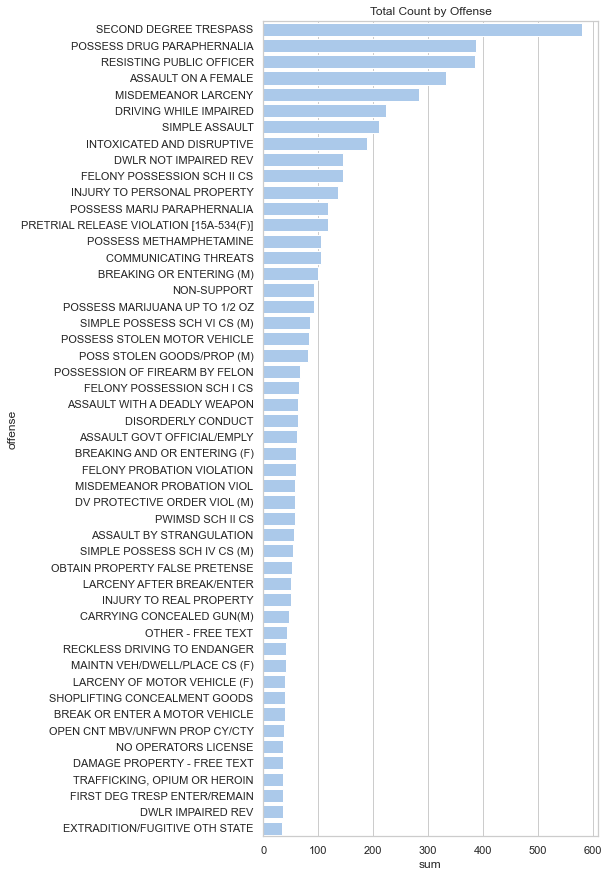

In [221]:
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
sns.barplot(x="sum", y="offense", data=arrest_bar[0:50], label = "Total", color = "b")
plt.title( "Total Count by Offense")

Collect venue data by neighborhood using the FourSquare API

In [225]:
CLIENT_ID = 'VKBN2JB0UTHRNRDT40G3EUN0FKLUUU11NBNGPVJFVYET300I' 
CLIENT_SECRET = '1FMHFZZFILBNV2EKSRACRGKU0RA1Z2WLDIYF4J40KTRK3RDW'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VKBN2JB0UTHRNRDT40G3EUN0FKLUUU11NBNGPVJFVYET300I
CLIENT_SECRET:1FMHFZZFILBNV2EKSRACRGKU0RA1Z2WLDIYF4J40KTRK3RDW


In [239]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

In [244]:
venues_asheville = getNearbyVenues(unique_df['hood'], unique_df['latitude'], unique_df['longitude'])

South Slope
Downtown
Bartlett Arms Apts
Downtown
Downtown
Altamont Apts
View Point
Erskine-Walton
Cloister Condominiums
Norwood Park
Downtown
Bartlett Arms Apts
Redwood Forest
Oak Forest
Shiloh
Pisgah View 
Wilshire Park
WECAN
North Downtown
Downtown
Altamont Apts
Altamont Apts
Hillside Terrace
Altamont Apts
Erskine-Walton
Hillcrest
Hillside Terrace
South French Broad
Montford
Biltmore Park
Altamont Apts
Burton Street
Livingston Heights
Aston Park Tower
Klondyke
East End/Valley Street
Blake Mountain
Wilshire Park
Cloister Condominiums
Wilshire Park
Cimarron
Klondyke
Pisgah View 
Burton Street
Enka Village
Burton Street
Kenilworth
Downtown
Livingston Heights
Burton Street
Shiloh
Hillside Terrace
Oak Forest
Hillcrest
Bartlett Arms Apts
Heart of Chestnut Hills
Biltmore Park
Pisgah View 
North Downtown
North Downtown
South Slope
Kenilworth
Burton Street
Pisgah View 
Bartlett Arms Apts
Beverly Hills
Altamont Apts
South French Broad
Enka Village
Falconhurst
View Point
Burton Street
Livingsto

count the number of venues

In [245]:
len(venues_asheville)

5465

In [246]:
venues_asheville.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,South Slope,35.58865,-82.554694,Catawba Brewing Co.,Brewery
1,South Slope,35.58865,-82.554694,Burial Beer Co.,Brewery
2,South Slope,35.58865,-82.554694,Green Man Brewery,Brewery
3,South Slope,35.58865,-82.554694,Funkatorium,Brewery
4,South Slope,35.58865,-82.554694,Vortex Doughnuts,Donut Shop


In [469]:
venue_bar = pd.DataFrame(venues_asheville['Venue Category'], columns = ['Venue Category'])
venue_bar['sum'] = 1
venue_bar = venue_bar.groupby(by=["Venue Category"], as_index=False).sum()

In [470]:
venue_bar.sort_values(by=['sum'], ascending = False, inplace=True)
venue_bar.head()

,Venue Category,sum
36,Brewery,261
122,Hotel,235
55,Coffee Shop,217
152,Mexican Restaurant,151
175,Pizza Place,148


Text(0.5, 1.0, 'Total Count by Venue Category')

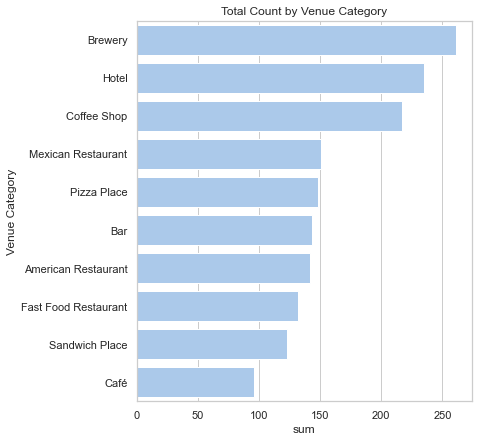

In [472]:
f, ax = plt.subplots(figsize=(6, 7))

sns.set_color_codes("pastel")
sns.barplot(x="sum", y="Venue Category", data=venue_bar[0:10], label = "Total", color = "b")
plt.title( "Total Count by Venue Category")

save venue list to csv file

In [247]:
venues_asheville.to_csv("venues_asheville.csv", index=False)

group and count the venues in each neighborhood

In [248]:
venues_asheville.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
Neighborhood,,,,
Albemarle Park,24,24,24,24
Altamont Apts,509,509,509,509
Aston Park Tower,86,86,86,86
Bartlett Arms Apts,49,49,49,49
Beverly Hills,15,15,15,15
Biltmore Park,147,147,147,147
Blake Mountain,77,77,77,77
Burton Street,330,330,330,330
Cimarron,32,32,32,32


In [249]:
print('There are {} uniques categories.'.format(len(venues_asheville['Venue Category'].unique())))

There are 251 uniques categories.


Create data frame for cluster analysis.  Need to one-hot-encode the venues.

In [250]:
# one hot encoding
asheville_onehot = pd.get_dummies(venues_asheville[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
asheville_onehot['Neighborhood'] = venues_asheville['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [asheville_onehot.columns[-1]] + list(asheville_onehot.columns[:-1])
asheville_onehot = asheville_onehot[fixed_columns]

asheville_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport,Airport Gate,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Cidery,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Cuban Restaurant,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hospice,Hostel,Hotel,Hotel Bar,Hotel Pool,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Motorsports Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightlife Spot,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outlet Mall,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,RV Park,Racetrack,Radio Station,Rafting,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel & Transport,Tunnel,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,South Slope,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sout

Create data frame with grouped venues, see the freq of a venue in a neighborhood

In [251]:
asheville_grouped = asheville_onehot.groupby('Neighborhood').mean().reset_index()
asheville_grouped.head()num_top_venues = 5

for hood in asheville_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = asheville_grouped[asheville_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport,Airport Gate,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Cidery,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Cuban Restaurant,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hospice,Hostel,Hotel,Hotel Bar,Hotel Pool,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Motorsports Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightlife Spot,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outlet Mall,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,RV Park,Racetrack,Radio Station,Rafting,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel & Transport,Tunnel,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Albemarle Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00

Let's see the top venues in each neighborhood

In [252]:
num_top_venues = 5

for hood in asheville_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = asheville_grouped[asheville_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albemarle Park----
               venue  freq
0             Lawyer  0.17
1     Ice Cream Shop  0.12
2                Pub  0.12
3  Electronics Store  0.12
4               Park  0.12


----Altamont Apts----
         venue  freq
0        Hotel  0.10
1  Coffee Shop  0.06
2     Wine Bar  0.05
3         Café  0.05
4          Bar  0.04


----Aston Park Tower----
         venue  freq
0      Brewery  0.09
1  Music Venue  0.08
2          Bar  0.08
3      Gay Bar  0.07
4     Wine Bar  0.07


----Bartlett Arms Apts----
                  venue  freq
0           Art Gallery  0.18
1           Coffee Shop  0.12
2           Pizza Place  0.08
3   Arts & Crafts Store  0.08
4  Gym / Fitness Center  0.06


----Beverly Hills----
                    venue  freq
0             Beer Garden  0.13
1                     ATM  0.07
2       Convenience Store  0.07
3                    Bank  0.07
4  Furniture / Home Store  0.07


----Biltmore Park----
                  venue  freq
0   Rental Car Location  0.09
1  

4   Print Shop  0.05


----Wilshire Park----
                  venue  freq
0    Mexican Restaurant  0.07
1        Sandwich Place  0.07
2  Fast Food Restaurant  0.06
3           Pizza Place  0.06
4           Gas Station  0.05




Lets create a data frame with the most common venues in each neighborhood

In [260]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [261]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = asheville_grouped['Neighborhood']

In [262]:
for ind in np.arange(asheville_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(asheville_grouped.iloc[ind, :], num_top_venues)

In [263]:
np.arange(asheville_grouped.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [264]:
asheville_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport,Airport Gate,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Cidery,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Cuban Restaurant,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hospice,Hostel,Hotel,Hotel Bar,Hotel Pool,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Motorsports Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightlife Spot,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outlet Mall,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,RV Park,Racetrack,Radio Station,Rafting,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel & Transport,Tunnel,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Albemarle Park,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.083333,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [265]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albemarle Park,Lawyer,Ice Cream Shop,Pub,Electronics Store,Park,Wine Shop,Bed & Breakfast,Home Service,Café,Massage Studio
1,Altamont Apts,Hotel,Coffee Shop,Café,Wine Bar,French Restaurant,Cocktail Bar,Chocolate Shop,Bar,Breakfast Spot,Italian Restaurant
2,Aston Park Tower,Brewery,Music Venue,Bar,Gay Bar,Wine Bar,Indie Movie Theater,Indian Restaurant,Hotel,Japanese Restaurant,Italian Restaurant
3,Bartlett Arms Apts,Art Gallery,Coffee Shop,Pizza Place,Arts & Crafts Store,Gym / Fitness Center,Furniture / Home Store,Brewery,Theater,Pet Store,Modern European Restaurant
4,Beverly Hills,Beer Garden,ATM,Convenience Store,Bank,Furniture / Home Store,Coffee Shop,Grocery Store,Pool,Art Gallery,Golf Course


Cluster analysis of venues in neighborhoods, use 5 clusters.  Lets see how the neighborhoods group together.

In [266]:
# set number of clusters
kclusters = 5

asheville_grouped_clustering = asheville_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(asheville_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 1, 1, 3, 1, 1, 1, 1], dtype=int32)

In [268]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [269]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Albemarle Park,Lawyer,Ice Cream Shop,Pub,Electronics Store,Park,Wine Shop,Bed & Breakfast,Home Service,Café,Massage Studio
1,3,Altamont Apts,Hotel,Coffee Shop,Café,Wine Bar,French Restaurant,Cocktail Bar,Chocolate Shop,Bar,Breakfast Spot,Italian Restaurant
2,3,Aston Park Tower,Brewery,Music Venue,Bar,Gay Bar,Wine Bar,Indie Movie Theater,Indian Restaurant,Hotel,Japanese Restaurant,Italian Restaurant
3,1,Bartlett Arms Apts,Art Gallery,Coffee Shop,Pizza Place,Arts & Crafts Store,Gym / Fitness Center,Furniture / Home Store,Brewery,Theater,Pet Store,Modern European Restaurant
4,1,Beverly Hills,Beer Garden,ATM,Convenience Store,Bank,Furniture / Home Store,Coffee Shop,Grocery Store,Pool,Art Gallery,Golf Course


We've added the cluster number to the data frame, now lets examine each cluster.

In [270]:
asheville_merged = neighborhoods_venues_sorted

In [ ]:
#asheville_merged = asheville_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [275]:
asheville_merged.loc[asheville_merged['Cluster Labels'] == 0, asheville_merged.columns[[1] + list(range(2, asheville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Lee Walker Heights,Brewery,Bar,American Restaurant,Beer Store,BBQ Joint,Breakfast Spot,Donut Shop,Chocolate Shop,Restaurant,Field
36,Oakhurst,Brewery,Bar,American Restaurant,Cocktail Bar,Liquor Store,Dessert Shop,Grocery Store,Chocolate Shop,Pharmacy,Mexican Restaurant
41,South French Broad,Brewery,Bar,Gym,Food Truck,Coffee Shop,Art Gallery,Music Venue,Arts & Crafts Store,Pet Store,Donut Shop
42,South Slope,Brewery,Bar,Mexican Restaurant,Donut Shop,Cocktail Bar,Dessert Shop,Beer Store,Japanese Restaurant,Rock Club,Grocery Store


In [473]:
asheville_merged.loc[asheville_merged['Cluster Labels'] == 1, asheville_merged.columns[[1] + list(range(2, asheville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albemarle Park,Lawyer,Ice Cream Shop,Pub,Electronics Store,Park,Wine Shop,Bed & Breakfast,Home Service,Café,Massage Studio
3,Bartlett Arms Apts,Art Gallery,Coffee Shop,Pizza Place,Arts & Crafts Store,Gym / Fitness Center,Furniture / Home Store,Brewery,Theater,Pet Store,Modern European Restaurant
4,Beverly Hills,Beer Garden,ATM,Convenience Store,Bank,Furniture / Home Store,Coffee Shop,Grocery Store,Pool,Art Gallery,Golf Course
6,Blake Mountain,Pizza Place,Fast Food Restaurant,Thai Restaurant,Mexican Restaurant,Café,Electronics Store,Sandwich Place,Thrift / Vintage Store,Hunting Supply,Convenience Store
7,Burton Street,Coffee Shop,Sandwich Place,Gym / Fitness Center,Mexican Restaurant,Mobile Phone Shop,Falafel Restaurant,Rental Car Location,Comic Shop,Breakfast Spot,Fast Food Restaurant
8,Cimarron,Gas Station,Hardware Store,Coffee Shop,American Restaurant,Video Store,Scenic Lookout,Pet Store,Pharmacy,Construction & Landscaping,Resort
9,Cloister Condominiums,Fabric Shop,Cosmetics Shop,Grocery Store,Home Service,Fast Food Restaurant,Shopping Mall,BBQ Joint,Pet Store,Department Store,Pizza Place
10,Crowfields Condominiums,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Gym,Frozen Yogurt Shop,Asian Restaurant,BBQ Joint,Movie Theater,Gym / Fitness Center,Salon / Barbershop
13,East West Asheville,Brewery,Bakery,Coffee Shop,Taco Place,Asian Restaurant,Pizza Place,Bar,Convention Center,Donut Shop,Airport
15,Erskine-Walton,Coffee Shop,Dance Studio,Hawaiian Restaurant,BBQ Joint,Skate Park,Food Truck,Brewery,Tech Startup,Park,Dog Run


In [474]:
asheville_merged.loc[asheville_merged['Cluster Labels'] == 2, asheville_merged.columns[[1] + list(range(2, asheville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Haw Creek,Pool,Baseball Field,ATM,Paper / Office Supplies Store,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant


In [475]:
asheville_merged.loc[asheville_merged['Cluster Labels'] == 3, asheville_merged.columns[[1] + list(range(2, asheville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Altamont Apts,Hotel,Coffee Shop,Café,Wine Bar,French Restaurant,Cocktail Bar,Chocolate Shop,Bar,Breakfast Spot,Italian Restaurant
2,Aston Park Tower,Brewery,Music Venue,Bar,Gay Bar,Wine Bar,Indie Movie Theater,Indian Restaurant,Hotel,Japanese Restaurant,Italian Restaurant
5,Biltmore Park,Rental Car Location,American Restaurant,Fast Food Restaurant,Coffee Shop,Hotel,Brewery,Italian Restaurant,IT Services,Clothing Store,Big Box Store
11,Downtown,Hotel,Coffee Shop,Brewery,Bar,Wine Bar,Mexican Restaurant,Chocolate Shop,Breakfast Spot,Café,Gastropub
12,East End/Valley Street,Hotel,Brewery,American Restaurant,Coffee Shop,Mexican Restaurant,Bar,Pizza Place,Park,Café,Bakery
14,Enka Village,Hotel,Fast Food Restaurant,Clothing Store,Pizza Place,Pharmacy,Video Store,Department Store,Sandwich Place,Diner,Fried Chicken Joint
21,Hillcrest,Shipping Store,Frozen Yogurt Shop,Hotel,Food Truck,Restaurant,Asian Restaurant,Deli / Bodega,Discount Store,Pharmacy,Salon / Barbershop
23,Hillside Terrace,Hotel,Fast Food Restaurant,American Restaurant,Construction & Landscaping,Ice Cream Shop,Hardware Store,Rental Car Location,Donut Shop,Gas Station,Motel
25,Kenilworth,Clothing Store,Hotel,Brewery,Antique Shop,Sandwich Place,Bed & Breakfast,Breakfast Spot,Toy / Game Store,Mobile Phone Shop,Gift Shop
34,Norwood Park,Ice Cream Shop,Fast Food Restaurant,Breakfast Spot,ATM,Video Store,Italian Restaurant,Pharmacy,Clothing Store,Burrito Place,Sushi Restaurant


In [476]:
asheville_merged.loc[asheville_merged['Cluster Labels'] == 4, asheville_merged.columns[[1] + list(range(2, asheville_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Hills of Beaverdam,Hobby Shop,Intersection,Nightlife Spot,Paper / Office Supplies Store,Outlet Mall,Other Repair Shop,Other Great Outdoors,Optical Shop,Office,ATM


Lets go through the same process with the arrest data, one hot encode the arrest data and cluster the arrest.  Let's see what arrest violations go together...

In [276]:
arrest_df.head()

,date,address,offense
0,2012-01-01,BARTLETT ST,SECOND DEGREE TRESPASS ...
1,2012-01-01,S SPRUCE ST,INTOXICATED AND DISRUPTIVE ...
2,2012-01-01,BILTMORE AVE,FEL HIT/RUN SER INJ/DEATH ...
3,2012-01-01,BILTMORE AVE,DRIVE AFTER CONSUMING < 21 ...
4,2012-01-01,BARTLETT ST,ASSAULT ON A FEMALE ...


In [278]:
arrest_df_current.head()

,date,address,offense,latitude,longitude,hood
0,2020-01-10,COXE AVE,MISDEMEANOR LARCENY,35.58865,-82.554694,South Slope
1,2020-01-07,COXE AVE,INTOXICATED AND DISRUPTIVE,35.58865,-82.554694,South Slope
2,2020-02-18,COXE AVE,DV PROTECTIVE ORDER VIOL (M),35.58865,-82.554694,South Slope
3,2020-05-07,COXE AVE,POSSESS MARIJUANA UP TO 1/2 OZ,35.58865,-82.554694,South Slope
4,2020-05-07,COXE AVE,POSSESS MARIJ PARAPHERNALIA,35.58865,-82.554694,South Slope


In [279]:
# one hot encoding
arrest_onehot = pd.get_dummies(arrest_df_current[['offense']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
arrest_onehot['Neighborhood'] = arrest_df_current['hood'] 

# move neighborhood column to the first column
fixed_columns = [arrest_onehot.columns[-1]] + list(arrest_onehot.columns[:-1])
arrest_onehot = arrest_onehot[fixed_columns]

arrest_onehot.head()

,Neighborhood,24 HOUR HOLD,A&A DWLR NOT IMPAIRED REV,A&A OBTAIN PROP FALSE PRETENSE,ABANDONMENT OF AN ANIMAL,ACCESSORY AFTER THE FACT (F),ACCESSORY AFTER THE FACT (M),AGGRESSIVE DRIVING,AID & ABET LARCENY (F),AID & ABET LARCENY (M),AID AND ABET ARMED ROBBERY,ALLOW CON MTBV/U-WN OFF PREM,ALTER TITLE,ALTER/DEST/ETC STOLEN MV/PART,ALTER/REMOVE GUN SERIAL NUMBER,ALTER/STEAL/DEST CRIMINAL EVID,ARSON - FREE TEXT,ASLT INF SER INJ MINOR PRESENT,ASSAULT - FREE TEXT,ASSAULT AND BATTERY,ASSAULT BY POINTING A GUN,ASSAULT BY STRANGULATION,ASSAULT GOVT OFFICIAL/EMPLY,ASSAULT INDIV W/ DISABILITY,ASSAULT INFLICT SERIOUS INJ(M),ASSAULT LEO/PO SER INJ,ASSAULT ON A CHILD UNDER 12,ASSAULT ON A FEMALE,ASSAULT PHY INJ DETENTION EMP,ASSAULT PHY INJ EMERGENCY PRSN,ASSAULT PHY INJ LE/PROB/PAR OF,ASSAULT PUBLIC TRANSIT OPERATR,ASSAULT SERIOUS BODILY INJURY,ASSAULT WITH A DEADLY WEAPON,ATT BREAK OR ENTER BLDG (F),ATT BREAK OR ENTER BLDG (M),ATT OBTAIN PROP FALSE PRETENSE,ATT ROBBERY-DANGEROUS WEAPON,ATTEMPT BREAK/ENTER MOTOR VEH,ATTEMPT FIRST DEGREE BURGLARY,ATTEMPTED COMMON LAW ROBBERY,ATTEMPTED FIRST DEGREE MURDER,ATTEMPTED LARCENY (F),ATTEMPTED LARCENY (M),ATTEMPTED UTTERING,AWDW GOVERNMENT OFFICIAL,AWDW INTENT TO KILL,AWDW SERIOUS INJURY,AWDWIKISI,BATTERY OF UNBORN CHILD,BREAK COIN/CURRENCY MACH (M),BREAK OR ENTER A MOTOR VEHICLE,BREAK/ENTER PLACE OF WORSHIP,BREAK/ENTER TERRORIZE/INJURE,BREAK/ENTER TRAILER/AIRCRAFT,BREAKING AND OR ENTERING (F),BREAKING OR ENTERING (M),BURGLARY - FREE TEXT,BURNING PERSONAL PROPERTY,CAMPING VIOLATIONS,CANCL/REVOK/SUSP CERTIF/TAG,CARRYING CONCEALED GUN(M),CARRYING CONCEALED WEAPON,CHILD ABUSE ASSAULTIVE (M),CHILD ABUSE NONASSAULTIVE (M),CITY/TOWN VIOLATION (M),CIVIL-OFA,COMMON LAW FORGERY (F),COMMON LAW OBSTRUCTION OF JUSTICE (F),COMMON LAW OBSTRUCTION OF JUSTICE (M),COMMON LAW ROBBERY,COMMUNICATING THREATS,CON MTBV/UN-WN OFF PREM PERMIT,CONSP B&E BLDG-FELONY/LARCENY,CONSP OBTAIN PROP FALSE PRET,CONSP ROBBERY DANGRS WEAPON,CONSPIRE COMMIT FEL LARCENY,CONSPIRE SELL SCH VI CS,CONSPIRE SELL/DELIVER HEROIN,CONSPIRE TO TRAFFIC IN COCAINE,CONSPIRE TO TRAFFIC IN MARIJ,CONSPIRE TRAFFIC METHAMPHETAMI,CONSPIRE TRAFFIC OPIUM/HEROIN,CONSUME ALC BY 19/20,CONSUME ALC BY <19,CONTINUING CRIMINAL ENTERPRISE,CONTRIBUTING DEL OF JUVENILE,COVERING/DISGUISING REG PLATE,CRIMINAL CONTEMPT,CRUELTY TO ANIMALS(M),CYBERSTALKING,DAMAGE PROPERTY - FREE TEXT,DANGEROUS DRUGS - FREE TEXT,DEFRAUDING INNKEEPER,DIS WEAP OCC DWELL/MOVING VEH,DIS WEAP OCC PROP SER BOD INJ,DISCHARGE FIREARM ENCL FEAR,DISCHARGE FIREARM IN CITY,DISCHARGE WEAPON OCCUPIED PROP,DISORDERLY CONDUCT,DISORDERLY CONDUCT PUBLIC BLDG,DISORDERLY CONDUCT-SCHOOL,DISPLAY ANOTHERS LIC AS OWN,DOMESTIC CRIM TRESPASS(M),DR/ALLOW REG PLATE NOT DISPLAY,DRIVE AFTER CONSUMING < 21,DRIVE LEFT OF CENTER,DRIVE WITHOUT TWO HEADLAMPS,DRIVE WRONG WAY ON DUAL LANE,DRIVE WRONG WAY-ONE WAY LOCAL,DRIVE WRONG WAY-ONE WAY ST/RD,DRIVE/ALLOW MV NO REGISTRATION,DRIVING WHILE IMPAIRED,DV PROTECTIVE ORDER VIOL (M),DWI - LEVEL 5,DWLR,DWLR AFT IMPAIRED REV NOTICE,DWLR IMPAIRED REV,DWLR NOT IMPAIRED REV,DWLR VIOL LIMITED DRIVE PRIV,EMBEZZLE - FREE TEXT,EMBEZZLEMENT,ENT/REM PK BEF/AFT HRS W/O PER,ETHNIC INTIMIDATION,EXCEEDING POSTED SPEED,EXCEEDING SAFE SPEED,EXPIRED OPERATORS LICENSE,EXPIRED REGISTRATION CARD/TAG,EXPIRED/NO INSPECTION,EXPLOIT DISABLE/ELDER TRUST,EXTORTION,EXTRADITION/FUGITIVE OTH STATE,FAIL COMPLY LIC RESTRICTIONS,FAIL EXHIBIT/SURRENDER LICENSE,FAIL MAINTAIN LANE CONTROL,FAIL REGISTER SEX OFFENDER(F),FAIL REPRT NEW ADDRESS-SEX OFF,FAIL RETURN HIRED MV >$4000,FAIL STOP STOPSIGN/FLSH RED LT,FAIL TO BURN HEADLAMPS,FAIL TO COMPLY-COST & FINES,FAIL TO DISPERSE ON COMMAND,FAIL TO GIVE INFO/AID PER INJ,FAIL TO HEED LIGHT OR SIREN,FAIL TO REPORT ACCIDENT,FAIL TO SECURE PASSEN UNDER 16,FAIL TO STOP-STEADY RED LIGHT,FAIL TO WEAR SEAT BELT-DRIVER,FAIL TO WORK AFTER PAID,FAILURE TO APPEAR ON FELONY,FAILURE TO APPEAR ON MISD,FAILURE TO REDUCE SPEED,FAILURE TO YIELD,FALSE ADVERTISING,FALSE BOMB REPORT,FALSE BOMB 

In [281]:
arrest_grouped = arrest_onehot.groupby('Neighborhood').mean().reset_index()
arrest_grouped.head()
num_top_venues = 5

for hood in arrest_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = arrest_grouped[arrest_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albemarle Park----
                          venue  freq
0        DRIVING WHILE IMPAIRED  0.17
1                SIMPLE ASSAULT  0.17
2   INJURY TO PERSONAL PROPERTY  0.08
3    INTOXICATED AND DISRUPTIVE  0.08
4  BREAKING AND OR ENTERING (F)  0.08


----Altamont Apts----
                         venue  freq
0       SECOND DEGREE TRESPASS  0.14
1     RESISTING PUBLIC OFFICER  0.06
2   POSSESS DRUG PARAPHERNALIA  0.05
3   INTOXICATED AND DISRUPTIVE  0.04
4  INJURY TO PERSONAL PROPERTY  0.03


----Aston Park Tower----
                         venue  freq
0       SECOND DEGREE TRESPASS  0.18
1     RESISTING PUBLIC OFFICER  0.08
2   POSSESS DRUG PARAPHERNALIA  0.07
3          MISDEMEANOR LARCENY  0.06
4  ASSAULT GOVT OFFICIAL/EMPLY  0.03


----Bartlett Arms Apts----
                        venue  freq
0         ASSAULT ON A FEMALE  0.10
1      SECOND DEGREE TRESPASS  0.06
2    RESISTING PUBLIC OFFICER  0.06
3  POSSESS DRUG PARAPHERNALIA  0.05
4          DISORDERLY CONDUCT  0.03


----Bev

4            PWIMSD SCH VI CS  0.02


----Wilshire Park----
                        venue  freq
0  POSSESS DRUG PARAPHERNALIA  0.06
1      SECOND DEGREE TRESPASS  0.06
2    RESISTING PUBLIC OFFICER  0.05
3         MISDEMEANOR LARCENY  0.04
4  INTOXICATED AND DISRUPTIVE  0.04




In [282]:
def return_most_common_arrests(row, num_top_arrests):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [298]:
num_top_arrests = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Arrest'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Arrest'.format(ind+1))

# create a new dataframe
neighborhoods_arrest_sorted = pd.DataFrame(columns=columns)
neighborhoods_arrest_sorted['Neighborhood'] = arrest_grouped['Neighborhood']

In [299]:
for ind in np.arange(arrest_grouped.shape[0]):
    neighborhoods_arrest_sorted.iloc[ind, 1:] = return_most_common_arrests(arrest_grouped.iloc[ind, :], num_top_arrests)

In [300]:
np.arange(arrest_grouped.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [301]:
arrest_grouped.head()

,Neighborhood,24 HOUR HOLD,A&A DWLR NOT IMPAIRED REV,A&A OBTAIN PROP FALSE PRETENSE,ABANDONMENT OF AN ANIMAL,ACCESSORY AFTER THE FACT (F),ACCESSORY AFTER THE FACT (M),AGGRESSIVE DRIVING,AID & ABET LARCENY (F),AID & ABET LARCENY (M),AID AND ABET ARMED ROBBERY,ALLOW CON MTBV/U-WN OFF PREM,ALTER TITLE,ALTER/DEST/ETC STOLEN MV/PART,ALTER/REMOVE GUN SERIAL NUMBER,ALTER/STEAL/DEST CRIMINAL EVID,ARSON - FREE TEXT,ASLT INF SER INJ MINOR PRESENT,ASSAULT - FREE TEXT,ASSAULT AND BATTERY,ASSAULT BY POINTING A GUN,ASSAULT BY STRANGULATION,ASSAULT GOVT OFFICIAL/EMPLY,ASSAULT INDIV W/ DISABILITY,ASSAULT INFLICT SERIOUS INJ(M),ASSAULT LEO/PO SER INJ,ASSAULT ON A CHILD UNDER 12,ASSAULT ON A FEMALE,ASSAULT PHY INJ DETENTION EMP,ASSAULT PHY INJ EMERGENCY PRSN,ASSAULT PHY INJ LE/PROB/PAR OF,ASSAULT PUBLIC TRANSIT OPERATR,ASSAULT SERIOUS BODILY INJURY,ASSAULT WITH A DEADLY WEAPON,ATT BREAK OR ENTER BLDG (F),ATT BREAK OR ENTER BLDG (M),ATT OBTAIN PROP FALSE PRETENSE,ATT ROBBERY-DANGEROUS WEAPON,ATTEMPT BREAK/ENTER MOTOR VEH,ATTEMPT FIRST DEGREE BURGLARY,ATTEMPTED COMMON LAW ROBBERY,ATTEMPTED FIRST DEGREE MURDER,ATTEMPTED LARCENY (F),ATTEMPTED LARCENY (M),ATTEMPTED UTTERING,AWDW GOVERNMENT OFFICIAL,AWDW INTENT TO KILL,AWDW SERIOUS INJURY,AWDWIKISI,BATTERY OF UNBORN CHILD,BREAK COIN/CURRENCY MACH (M),BREAK OR ENTER A MOTOR VEHICLE,BREAK/ENTER PLACE OF WORSHIP,BREAK/ENTER TERRORIZE/INJURE,BREAK/ENTER TRAILER/AIRCRAFT,BREAKING AND OR ENTERING (F),BREAKING OR ENTERING (M),BURGLARY - FREE TEXT,BURNING PERSONAL PROPERTY,CAMPING VIOLATIONS,CANCL/REVOK/SUSP CERTIF/TAG,CARRYING CONCEALED GUN(M),CARRYING CONCEALED WEAPON,CHILD ABUSE ASSAULTIVE (M),CHILD ABUSE NONASSAULTIVE (M),CITY/TOWN VIOLATION (M),CIVIL-OFA,COMMON LAW FORGERY (F),COMMON LAW OBSTRUCTION OF JUSTICE (F),COMMON LAW OBSTRUCTION OF JUSTICE (M),COMMON LAW ROBBERY,COMMUNICATING THREATS,CON MTBV/UN-WN OFF PREM PERMIT,CONSP B&E BLDG-FELONY/LARCENY,CONSP OBTAIN PROP FALSE PRET,CONSP ROBBERY DANGRS WEAPON,CONSPIRE COMMIT FEL LARCENY,CONSPIRE SELL SCH VI CS,CONSPIRE SELL/DELIVER HEROIN,CONSPIRE TO TRAFFIC IN COCAINE,CONSPIRE TO TRAFFIC IN MARIJ,CONSPIRE TRAFFIC METHAMPHETAMI,CONSPIRE TRAFFIC OPIUM/HEROIN,CONSUME ALC BY 19/20,CONSUME ALC BY <19,CONTINUING CRIMINAL ENTERPRISE,CONTRIBUTING DEL OF JUVENILE,COVERING/DISGUISING REG PLATE,CRIMINAL CONTEMPT,CRUELTY TO ANIMALS(M),CYBERSTALKING,DAMAGE PROPERTY - FREE TEXT,DANGEROUS DRUGS - FREE TEXT,DEFRAUDING INNKEEPER,DIS WEAP OCC DWELL/MOVING VEH,DIS WEAP OCC PROP SER BOD INJ,DISCHARGE FIREARM ENCL FEAR,DISCHARGE FIREARM IN CITY,DISCHARGE WEAPON OCCUPIED PROP,DISORDERLY CONDUCT,DISORDERLY CONDUCT PUBLIC BLDG,DISORDERLY CONDUCT-SCHOOL,DISPLAY ANOTHERS LIC AS OWN,DOMESTIC CRIM TRESPASS(M),DR/ALLOW REG PLATE NOT DISPLAY,DRIVE AFTER CONSUMING < 21,DRIVE LEFT OF CENTER,DRIVE WITHOUT TWO HEADLAMPS,DRIVE WRONG WAY ON DUAL LANE,DRIVE WRONG WAY-ONE WAY LOCAL,DRIVE WRONG WAY-ONE WAY ST/RD,DRIVE/ALLOW MV NO REGISTRATION,DRIVING WHILE IMPAIRED,DV PROTECTIVE ORDER VIOL (M),DWI - LEVEL 5,DWLR,DWLR AFT IMPAIRED REV NOTICE,DWLR IMPAIRED REV,DWLR NOT IMPAIRED REV,DWLR VIOL LIMITED DRIVE PRIV,EMBEZZLE - FREE TEXT,EMBEZZLEMENT,ENT/REM PK BEF/AFT HRS W/O PER,ETHNIC INTIMIDATION,EXCEEDING POSTED SPEED,EXCEEDING SAFE SPEED,EXPIRED OPERATORS LICENSE,EXPIRED REGISTRATION CARD/TAG,EXPIRED/NO INSPECTION,EXPLOIT DISABLE/ELDER TRUST,EXTORTION,EXTRADITION/FUGITIVE OTH STATE,FAIL COMPLY LIC RESTRICTIONS,FAIL EXHIBIT/SURRENDER LICENSE,FAIL MAINTAIN LANE CONTROL,FAIL REGISTER SEX OFFENDER(F),FAIL REPRT NEW ADDRESS-SEX OFF,FAIL RETURN HIRED MV >$4000,FAIL STOP STOPSIGN/FLSH RED LT,FAIL TO BURN HEADLAMPS,FAIL TO COMPLY-COST & FINES,FAIL TO DISPERSE ON COMMAND,FAIL TO GIVE INFO/AID PER INJ,FAIL TO HEED LIGHT OR SIREN,FAIL TO REPORT ACCIDENT,FAIL TO SECURE PASSEN UNDER 16,FAIL TO STOP-STEADY RED LIGHT,FAIL TO WEAR SEAT BELT-DRIVER,FAIL TO WORK AFTER PAID,FAILURE TO APPEAR ON FELONY,FAILURE TO APPEAR ON MISD,FAILURE TO REDUCE SPEED,FAILURE TO YIELD,FALSE ADVERTISING,FALSE BOMB REPORT,FALSE BOMB 

In [302]:
neighborhoods_arrest_sorted.head()

,Neighborhood,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest,4th Most Common Arrest,5th Most Common Arrest,6th Most Common Arrest,7th Most Common Arrest,8th Most Common Arrest,9th Most Common Arrest,10th Most Common Arrest
0,Albemarle Park,DRIVING WHILE IMPAIRED,SIMPLE ASSAULT,INJURY TO PERSONAL PROPERTY,INTOXICATED AND DISRUPTIVE,BREAKING AND OR ENTERING (F),BREAKING OR ENTERING (M),RECKLESS DRVG-WANTON DISREGARD,LARCENY AFTER BREAK/ENTER,EXCEEDING SAFE SPEED,TAMPERING WITH VEHICLE
1,Altamont Apts,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,INTOXICATED AND DISRUPTIVE,ASSAULT ON A FEMALE,FELONY POSSESSION SCH II CS,INJURY TO PERSONAL PROPERTY,DRIVING WHILE IMPAIRED,DISORDERLY CONDUCT,POSSESS MARIJ PARAPHERNALIA
2,Aston Park Tower,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,MISDEMEANOR LARCENY,ASSAULT GOVT OFFICIAL/EMPLY,BREAKING OR ENTERING (M),ASSAULT ON A FEMALE,FIRST DEG TRESP ENTER/REMAIN,DRIVING WHILE IMPAIRED,INTOXICATED AND DISRUPTIVE
3,Bartlett Arms Apts,ASSAULT ON A FEMALE,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,DISORDERLY CONDUCT,SIMPLE ASSAULT,INTOXICATED AND DISRUPTIVE,MISDEMEANOR PROBATION VIOL,FELONY POSSESSION SCH II CS,POSSESS MARIJUANA UP TO 1/2 OZ
4,Beverly Hills,24 HOUR HOLD,DV PROTECTIVE ORDER VIOL (M),BREAKING OR ENTERING (M),RESISTING PUBLIC OFFICER,SECOND DEGREE TRESPASS,LARCENY BY EMPLOYEE,MISDEMEANOR LARCENY,INJURY TO REAL PROPERTY,INJURY TO PERSONAL PROPERTY,FELONY LARCENY


In [303]:
# set number of clusters
kclusters = 5

arrest_grouped_clustering = arrest_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(arrest_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [304]:
arrest_grouped_clustering.head()

,24 HOUR HOLD,A&A DWLR NOT IMPAIRED REV,A&A OBTAIN PROP FALSE PRETENSE,ABANDONMENT OF AN ANIMAL,ACCESSORY AFTER THE FACT (F),ACCESSORY AFTER THE FACT (M),AGGRESSIVE DRIVING,AID & ABET LARCENY (F),AID & ABET LARCENY (M),AID AND ABET ARMED ROBBERY,ALLOW CON MTBV/U-WN OFF PREM,ALTER TITLE,ALTER/DEST/ETC STOLEN MV/PART,ALTER/REMOVE GUN SERIAL NUMBER,ALTER/STEAL/DEST CRIMINAL EVID,ARSON - FREE TEXT,ASLT INF SER INJ MINOR PRESENT,ASSAULT - FREE TEXT,ASSAULT AND BATTERY,ASSAULT BY POINTING A GUN,ASSAULT BY STRANGULATION,ASSAULT GOVT OFFICIAL/EMPLY,ASSAULT INDIV W/ DISABILITY,ASSAULT INFLICT SERIOUS INJ(M),ASSAULT LEO/PO SER INJ,ASSAULT ON A CHILD UNDER 12,ASSAULT ON A FEMALE,ASSAULT PHY INJ DETENTION EMP,ASSAULT PHY INJ EMERGENCY PRSN,ASSAULT PHY INJ LE/PROB/PAR OF,ASSAULT PUBLIC TRANSIT OPERATR,ASSAULT SERIOUS BODILY INJURY,ASSAULT WITH A DEADLY WEAPON,ATT BREAK OR ENTER BLDG (F),ATT BREAK OR ENTER BLDG (M),ATT OBTAIN PROP FALSE PRETENSE,ATT ROBBERY-DANGEROUS WEAPON,ATTEMPT BREAK/ENTER MOTOR VEH,ATTEMPT FIRST DEGREE BURGLARY,ATTEMPTED COMMON LAW ROBBERY,ATTEMPTED FIRST DEGREE MURDER,ATTEMPTED LARCENY (F),ATTEMPTED LARCENY (M),ATTEMPTED UTTERING,AWDW GOVERNMENT OFFICIAL,AWDW INTENT TO KILL,AWDW SERIOUS INJURY,AWDWIKISI,BATTERY OF UNBORN CHILD,BREAK COIN/CURRENCY MACH (M),BREAK OR ENTER A MOTOR VEHICLE,BREAK/ENTER PLACE OF WORSHIP,BREAK/ENTER TERRORIZE/INJURE,BREAK/ENTER TRAILER/AIRCRAFT,BREAKING AND OR ENTERING (F),BREAKING OR ENTERING (M),BURGLARY - FREE TEXT,BURNING PERSONAL PROPERTY,CAMPING VIOLATIONS,CANCL/REVOK/SUSP CERTIF/TAG,CARRYING CONCEALED GUN(M),CARRYING CONCEALED WEAPON,CHILD ABUSE ASSAULTIVE (M),CHILD ABUSE NONASSAULTIVE (M),CITY/TOWN VIOLATION (M),CIVIL-OFA,COMMON LAW FORGERY (F),COMMON LAW OBSTRUCTION OF JUSTICE (F),COMMON LAW OBSTRUCTION OF JUSTICE (M),COMMON LAW ROBBERY,COMMUNICATING THREATS,CON MTBV/UN-WN OFF PREM PERMIT,CONSP B&E BLDG-FELONY/LARCENY,CONSP OBTAIN PROP FALSE PRET,CONSP ROBBERY DANGRS WEAPON,CONSPIRE COMMIT FEL LARCENY,CONSPIRE SELL SCH VI CS,CONSPIRE SELL/DELIVER HEROIN,CONSPIRE TO TRAFFIC IN COCAINE,CONSPIRE TO TRAFFIC IN MARIJ,CONSPIRE TRAFFIC METHAMPHETAMI,CONSPIRE TRAFFIC OPIUM/HEROIN,CONSUME ALC BY 19/20,CONSUME ALC BY <19,CONTINUING CRIMINAL ENTERPRISE,CONTRIBUTING DEL OF JUVENILE,COVERING/DISGUISING REG PLATE,CRIMINAL CONTEMPT,CRUELTY TO ANIMALS(M),CYBERSTALKING,DAMAGE PROPERTY - FREE TEXT,DANGEROUS DRUGS - FREE TEXT,DEFRAUDING INNKEEPER,DIS WEAP OCC DWELL/MOVING VEH,DIS WEAP OCC PROP SER BOD INJ,DISCHARGE FIREARM ENCL FEAR,DISCHARGE FIREARM IN CITY,DISCHARGE WEAPON OCCUPIED PROP,DISORDERLY CONDUCT,DISORDERLY CONDUCT PUBLIC BLDG,DISORDERLY CONDUCT-SCHOOL,DISPLAY ANOTHERS LIC AS OWN,DOMESTIC CRIM TRESPASS(M),DR/ALLOW REG PLATE NOT DISPLAY,DRIVE AFTER CONSUMING < 21,DRIVE LEFT OF CENTER,DRIVE WITHOUT TWO HEADLAMPS,DRIVE WRONG WAY ON DUAL LANE,DRIVE WRONG WAY-ONE WAY LOCAL,DRIVE WRONG WAY-ONE WAY ST/RD,DRIVE/ALLOW MV NO REGISTRATION,DRIVING WHILE IMPAIRED,DV PROTECTIVE ORDER VIOL (M),DWI - LEVEL 5,DWLR,DWLR AFT IMPAIRED REV NOTICE,DWLR IMPAIRED REV,DWLR NOT IMPAIRED REV,DWLR VIOL LIMITED DRIVE PRIV,EMBEZZLE - FREE TEXT,EMBEZZLEMENT,ENT/REM PK BEF/AFT HRS W/O PER,ETHNIC INTIMIDATION,EXCEEDING POSTED SPEED,EXCEEDING SAFE SPEED,EXPIRED OPERATORS LICENSE,EXPIRED REGISTRATION CARD/TAG,EXPIRED/NO INSPECTION,EXPLOIT DISABLE/ELDER TRUST,EXTORTION,EXTRADITION/FUGITIVE OTH STATE,FAIL COMPLY LIC RESTRICTIONS,FAIL EXHIBIT/SURRENDER LICENSE,FAIL MAINTAIN LANE CONTROL,FAIL REGISTER SEX OFFENDER(F),FAIL REPRT NEW ADDRESS-SEX OFF,FAIL RETURN HIRED MV >$4000,FAIL STOP STOPSIGN/FLSH RED LT,FAIL TO BURN HEADLAMPS,FAIL TO COMPLY-COST & FINES,FAIL TO DISPERSE ON COMMAND,FAIL TO GIVE INFO/AID PER INJ,FAIL TO HEED LIGHT OR SIREN,FAIL TO REPORT ACCIDENT,FAIL TO SECURE PASSEN UNDER 16,FAIL TO STOP-STEADY RED LIGHT,FAIL TO WEAR SEAT BELT-DRIVER,FAIL TO WORK AFTER PAID,FAILURE TO APPEAR ON FELONY,FAILURE TO APPEAR ON MISD,FAILURE TO REDUCE SPEED,FAILURE TO YIELD,FALSE ADVERTISING,FALSE BOMB REPORT,FALSE BOMB REPORT PUBLIC

In [305]:
# add clustering labels
neighborhoods_arrest_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [308]:
arrest_merged = neighborhoods_arrest_sorted

In [386]:
arrest_merged

,Cluster Labels,Neighborhood,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest,4th Most Common Arrest,5th Most Common Arrest,6th Most Common Arrest,7th Most Common Arrest,8th Most Common Arrest,9th Most Common Arrest,10th Most Common Arrest
0,2,Albemarle Park,DRIVING WHILE IMPAIRED,SIMPLE ASSAULT,INJURY TO PERSONAL PROPERTY,INTOXICATED AND DISRUPTIVE,BREAKING AND OR ENTERING (F),BREAKING OR ENTERING (M),RECKLESS DRVG-WANTON DISREGARD,LARCENY AFTER BREAK/ENTER,EXCEEDING SAFE SPEED,TAMPERING WITH VEHICLE
1,2,Altamont Apts,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,INTOXICATED AND DISRUPTIVE,ASSAULT ON A FEMALE,FELONY POSSESSION SCH II CS,INJURY TO PERSONAL PROPERTY,DRIVING WHILE IMPAIRED,DISORDERLY CONDUCT,POSSESS MARIJ PARAPHERNALIA
2,2,Aston Park Tower,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,MISDEMEANOR LARCENY,ASSAULT GOVT OFFICIAL/EMPLY,BREAKING OR ENTERING (M),ASSAULT ON A FEMALE,FIRST DEG TRESP ENTER/REMAIN,DRIVING WHILE IMPAIRED,INTOXICATED AND DISRUPTIVE
3,2,Bartlett Arms Apts,ASSAULT ON A FEMALE,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,DISORDERLY CONDUCT,SIMPLE ASSAULT,INTOXICATED AND DISRUPTIVE,MISDEMEANOR PROBATION VIOL,FELONY POSSESSION SCH II CS,POSSESS MARIJUANA UP TO 1/2 OZ
4,2,Beverly Hills,24 HOUR HOLD,DV PROTECTIVE ORDER VIOL (M),BREAKING OR ENTERING (M),RESISTING PUBLIC OFFICER,SECOND DEGREE TRESPASS,LARCENY BY EMPLOYEE,MISDEMEANOR LARCENY,INJURY TO REAL PROPERTY,INJURY TO PERSONAL PROPERTY,FELONY LARCENY
5,2,Biltmore Park,SECOND DEGREE TRESPASS,DRIVING WHILE IMPAIRED,DWLR NOT IMPAIRED REV,MISDEMEANOR LARCENY,RESISTING PUBLIC OFFICER,INTOXICATED AND DISRUPTIVE,POSSESS DRUG PARAPHERNALIA,SIMPLE POSSESS SCH IV CS (M),FAILURE TO REDUCE SPEED,POSSESS MARIJ PARAPHERNALIA
6,2,Blake Mountain,ASSAULT ON A FEMALE,FORGERY OF INSTRUMENT,ASSAULT ON A CHILD UNDER 12,DRIVING WHILE IMPAIRED,DWLR NOT IMPAIRED REV,OPEN CONT AFTER CONS ALC 1ST,PRETRIAL RELEASE VIOLATION [15A-534(F)],NEG CHILD ABUSE-SER BOD INJ,EXTRADITION/FUGITIVE OTH STATE,CARRYING CONCEALED GUN(M)
7,2,Burton Street,POSSESS DRUG PARAPHERNALIA,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS,DRIVING WHILE IMPAIRED,ASSAULT ON A FEMALE,RESISTING PUBLIC OFFICER,INTOXICATED AND DISRUPTIVE,FELONY POSSESSION SCH II CS,POSSESS MARIJ PARAPHERNALIA,INJURY TO PERSONAL PROPERTY
8,2,Cimarron,ASSAULT ON A FEMALE,DRIVING WHILE IMPAIRED,SIMPLE ASSAULT,SECOND DEGREE TRESPASS,ASSAULT WITH A DEADLY WEAPON,RESISTING PUBLIC OFFICER,INJURY TO REAL PROPERTY,HIT/RUN FAIL STOP PROP DAMAGE,DV PROTECTIVE ORDER VIOL (M),SIMPLE POSSESS SCH VI CS (M)
9,2,Cloister Condominiums,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS,POSSESS DRUG PARAPHERNALIA,RESISTING PUBLIC OFFICER,POSSESS METHAMPHETAMINE,DRIVING WHILE IMPAIRED,SHOPLIFTING CONCEALMENT GOODS,ASSAULT ON A FEMALE,PRETRIAL RELEASE VIOLATION [15A-534(F)],LAR REMOVE/DEST/DEACT COMPO


In [313]:
arrest_merged.loc[arrest_merged['Cluster Labels'] == 0, arrest_merged.columns[[1] + list(range(2, arrest_merged.shape[1]))]]

,Neighborhood,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest,4th Most Common Arrest,5th Most Common Arrest,6th Most Common Arrest,7th Most Common Arrest,8th Most Common Arrest,9th Most Common Arrest,10th Most Common Arrest
19,Grove Park/Sunset,ASSAULT ON A FEMALE,DWLR NOT IMPAIRED REV,DRIVING WHILE IMPAIRED,MIRROR VIOLATION,NEG CHILD ABUSE-SER BOD INJ,MOTIONS,MISUSE OF 911 SYSTEM,MISDEMEANOR STALKING,MISDEMEANOR PROBATION VIOL,MISDEMEANOR LARCENY
44,Spears-Henrietta,ASSAULT ON A FEMALE,SECOND DEGREE TRESPASS,FAIL COMPLY LIC RESTRICTIONS,DRIVING WHILE IMPAIRED,MANUFACTURE METHAMPHETAMINE,MOTIONS,MISUSE OF 911 SYSTEM,MISDEMEANOR STALKING,MISDEMEANOR PROBATION VIOL,MISDEMEANOR LARCENY


In [477]:
arrest_merged.loc[arrest_merged['Cluster Labels'] == 1, arrest_merged.columns[[1] + list(range(2, arrest_merged.shape[1]))]]

,Neighborhood,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest,4th Most Common Arrest,5th Most Common Arrest,6th Most Common Arrest,7th Most Common Arrest,8th Most Common Arrest,9th Most Common Arrest,10th Most Common Arrest
37,Oakhurst,24 HOUR HOLD,MANUFACTURE MARIJUANA,MOTIONS,MISUSE OF 911 SYSTEM,MISDEMEANOR STALKING,MISDEMEANOR PROBATION VIOL,MISDEMEANOR LARCENY,MISDEMEANOR CONSPIRACY,MISD PROB VIOL OUT OF COUNTY,MIRROR VIOLATION


In [478]:
arrest_merged.loc[arrest_merged['Cluster Labels'] == 2, arrest_merged.columns[[1] + list(range(2, arrest_merged.shape[1]))]]

,Neighborhood,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest,4th Most Common Arrest,5th Most Common Arrest,6th Most Common Arrest,7th Most Common Arrest,8th Most Common Arrest,9th Most Common Arrest,10th Most Common Arrest
0,Albemarle Park,DRIVING WHILE IMPAIRED,SIMPLE ASSAULT,INJURY TO PERSONAL PROPERTY,INTOXICATED AND DISRUPTIVE,BREAKING AND OR ENTERING (F),BREAKING OR ENTERING (M),RECKLESS DRVG-WANTON DISREGARD,LARCENY AFTER BREAK/ENTER,EXCEEDING SAFE SPEED,TAMPERING WITH VEHICLE
1,Altamont Apts,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,INTOXICATED AND DISRUPTIVE,ASSAULT ON A FEMALE,FELONY POSSESSION SCH II CS,INJURY TO PERSONAL PROPERTY,DRIVING WHILE IMPAIRED,DISORDERLY CONDUCT,POSSESS MARIJ PARAPHERNALIA
2,Aston Park Tower,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,MISDEMEANOR LARCENY,ASSAULT GOVT OFFICIAL/EMPLY,BREAKING OR ENTERING (M),ASSAULT ON A FEMALE,FIRST DEG TRESP ENTER/REMAIN,DRIVING WHILE IMPAIRED,INTOXICATED AND DISRUPTIVE
3,Bartlett Arms Apts,ASSAULT ON A FEMALE,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,DISORDERLY CONDUCT,SIMPLE ASSAULT,INTOXICATED AND DISRUPTIVE,MISDEMEANOR PROBATION VIOL,FELONY POSSESSION SCH II CS,POSSESS MARIJUANA UP TO 1/2 OZ
4,Beverly Hills,24 HOUR HOLD,DV PROTECTIVE ORDER VIOL (M),BREAKING OR ENTERING (M),RESISTING PUBLIC OFFICER,SECOND DEGREE TRESPASS,LARCENY BY EMPLOYEE,MISDEMEANOR LARCENY,INJURY TO REAL PROPERTY,INJURY TO PERSONAL PROPERTY,FELONY LARCENY
5,Biltmore Park,SECOND DEGREE TRESPASS,DRIVING WHILE IMPAIRED,DWLR NOT IMPAIRED REV,MISDEMEANOR LARCENY,RESISTING PUBLIC OFFICER,INTOXICATED AND DISRUPTIVE,POSSESS DRUG PARAPHERNALIA,SIMPLE POSSESS SCH IV CS (M),FAILURE TO REDUCE SPEED,POSSESS MARIJ PARAPHERNALIA
6,Blake Mountain,ASSAULT ON A FEMALE,FORGERY OF INSTRUMENT,ASSAULT ON A CHILD UNDER 12,DRIVING WHILE IMPAIRED,DWLR NOT IMPAIRED REV,OPEN CONT AFTER CONS ALC 1ST,PRETRIAL RELEASE VIOLATION [15A-534(F)],NEG CHILD ABUSE-SER BOD INJ,EXTRADITION/FUGITIVE OTH STATE,CARRYING CONCEALED GUN(M)
7,Burton Street,POSSESS DRUG PARAPHERNALIA,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS,DRIVING WHILE IMPAIRED,ASSAULT ON A FEMALE,RESISTING PUBLIC OFFICER,INTOXICATED AND DISRUPTIVE,FELONY POSSESSION SCH II CS,POSSESS MARIJ PARAPHERNALIA,INJURY TO PERSONAL PROPERTY
8,Cimarron,ASSAULT ON A FEMALE,DRIVING WHILE IMPAIRED,SIMPLE ASSAULT,SECOND DEGREE TRESPASS,ASSAULT WITH A DEADLY WEAPON,RESISTING PUBLIC OFFICER,INJURY TO REAL PROPERTY,HIT/RUN FAIL STOP PROP DAMAGE,DV PROTECTIVE ORDER VIOL (M),SIMPLE POSSESS SCH VI CS (M)
9,Cloister Condominiums,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS,POSSESS DRUG PARAPHERNALIA,RESISTING PUBLIC OFFICER,POSSESS METHAMPHETAMINE,DRIVING WHILE IMPAIRED,SHOPLIFTING CONCEALMENT GOODS,ASSAULT ON A FEMALE,PRETRIAL RELEASE VIOLATION [15A-534(F)],LAR REMOVE/DEST/DEACT COMPO


In [479]:
arrest_merged.loc[arrest_merged['Cluster Labels'] == 3, arrest_merged.columns[[1] + list(range(2, arrest_merged.shape[1]))]]

,Neighborhood,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest,4th Most Common Arrest,5th Most Common Arrest,6th Most Common Arrest,7th Most Common Arrest,8th Most Common Arrest,9th Most Common Arrest,10th Most Common Arrest
10,Crowfields Condominiums,ASSAULT ON A FEMALE,24 HOUR HOLD,LARCENY OF CHOSE IN ACTION,MOTIONS,MISUSE OF 911 SYSTEM,MISDEMEANOR STALKING,MISDEMEANOR PROBATION VIOL,MISDEMEANOR LARCENY,MISDEMEANOR CONSPIRACY,MISD PROB VIOL OUT OF COUNTY


In [480]:
arrest_merged.loc[arrest_merged['Cluster Labels'] == 4, arrest_merged.columns[[1] + list(range(2, arrest_merged.shape[1]))]]

,Neighborhood,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest,4th Most Common Arrest,5th Most Common Arrest,6th Most Common Arrest,7th Most Common Arrest,8th Most Common Arrest,9th Most Common Arrest,10th Most Common Arrest
28,Lake View Park,COMMUNICATING THREATS,ASSAULT SERIOUS BODILY INJURY,DRIVING WHILE IMPAIRED,24 HOUR HOLD,MIRROR VIOLATION,MOTIONS,MISUSE OF 911 SYSTEM,MISDEMEANOR STALKING,MISDEMEANOR PROBATION VIOL,MISDEMEANOR LARCENY


Now lets combine the venue and arrest data by neighborhood and see how they cluster together.  Following the same process as above...

In [322]:
combined_group = asheville_grouped.merge(arrest_grouped)

In [323]:
combined_group.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport,Airport Gate,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Cidery,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Cuban Restaurant,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hospice,Hostel,Hotel,Hotel Bar,Hotel Pool,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Motorsports Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightlife Spot,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outlet Mall,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,RV Park,Racetrack,Radio Station,Rafting,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel & Transport,Tunnel,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,24 HOUR HOLD,A&A DWLR NOT IMPAIRED REV,A&A OBTAIN PROP FALSE PRETENSE,ABANDONMENT OF AN ANIMAL,ACCESSORY AFTER THE FACT (F),ACCESSORY AFTER THE FACT (M),AGGRESSIVE DRIVING,AID & ABET LARCENY (F),AID & ABET LARCENY (M),AID AND ABET ARMED ROBBERY,ALLOW CON MTBV/U-WN OFF PREM,ALTER TITLE,ALTER/DEST/ETC STOLEN MV/PART,ALTER/REMOVE GUN SERIAL NUMBER,ALTER/STEAL/DEST CRIMINAL EVID,ARSON - FREE TEXT,ASLT INF SER INJ MINOR PRESENT,ASSAULT - FREE TEXT,ASSAULT AND BATTERY,ASSAULT BY POINTING A GUN,ASSAULT BY STRANGULATION,ASSA

To simplify the view, lets limit the number of venues and arrests to the top 3 per neighborhood.

In [395]:
merge1 = arrest_merged.iloc[:, 1:5]
merge2 = asheville_merged.iloc[:, 1:5]
merge2 = merge2.merge(merge1)

In [396]:
# set number of clusters
kclusters = 10

combined_grouped_clustering = combined_group.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(combined_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 6, 0, 0, 0, 0, 0], dtype=int32)

In [397]:
# add clustering labels
merge2.insert(0, 'Cluster Labels', kmeans.labels_)

In [398]:
merge2

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest
0,0,Albemarle Park,Lawyer,Ice Cream Shop,Pub,DRIVING WHILE IMPAIRED,SIMPLE ASSAULT,INJURY TO PERSONAL PROPERTY
1,0,Altamont Apts,Hotel,Coffee Shop,Café,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA
2,0,Aston Park Tower,Brewery,Music Venue,Bar,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA
3,0,Bartlett Arms Apts,Art Gallery,Coffee Shop,Pizza Place,ASSAULT ON A FEMALE,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER
4,6,Beverly Hills,Beer Garden,ATM,Convenience Store,24 HOUR HOLD,DV PROTECTIVE ORDER VIOL (M),BREAKING OR ENTERING (M)
5,0,Biltmore Park,Rental Car Location,American Restaurant,Fast Food Restaurant,SECOND DEGREE TRESPASS,DRIVING WHILE IMPAIRED,DWLR NOT IMPAIRED REV
6,0,Blake Mountain,Pizza Place,Fast Food Restaurant,Thai Restaurant,ASSAULT ON A FEMALE,FORGERY OF INSTRUMENT,ASSAULT ON A CHILD UNDER 12
7,0,Burton Street,Coffee Shop,Sandwich Place,Gym / Fitness Center,POSSESS DRUG PARAPHERNALIA,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS
8,0,Cimarron,Gas Station,Hardware Store,Coffee Shop,ASSAULT ON A FEMALE,DRIVING WHILE IMPAIRED,SIMPLE ASSAULT
9,0,Cloister Condominiums,Fabric Shop,Cosmetics Shop,Grocery Store,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS,POSSESS DRUG PARAPHERNALIA


In [399]:
merge2.loc[merge2['Cluster Labels'] == 0, merge2.columns[[1] + list(range(2, 8))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest
0,Albemarle Park,Lawyer,Ice Cream Shop,Pub,DRIVING WHILE IMPAIRED,SIMPLE ASSAULT,INJURY TO PERSONAL PROPERTY
1,Altamont Apts,Hotel,Coffee Shop,Café,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA
2,Aston Park Tower,Brewery,Music Venue,Bar,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA
3,Bartlett Arms Apts,Art Gallery,Coffee Shop,Pizza Place,ASSAULT ON A FEMALE,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER
5,Biltmore Park,Rental Car Location,American Restaurant,Fast Food Restaurant,SECOND DEGREE TRESPASS,DRIVING WHILE IMPAIRED,DWLR NOT IMPAIRED REV
6,Blake Mountain,Pizza Place,Fast Food Restaurant,Thai Restaurant,ASSAULT ON A FEMALE,FORGERY OF INSTRUMENT,ASSAULT ON A CHILD UNDER 12
7,Burton Street,Coffee Shop,Sandwich Place,Gym / Fitness Center,POSSESS DRUG PARAPHERNALIA,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS
8,Cimarron,Gas Station,Hardware Store,Coffee Shop,ASSAULT ON A FEMALE,DRIVING WHILE IMPAIRED,SIMPLE ASSAULT
9,Cloister Condominiums,Fabric Shop,Cosmetics Shop,Grocery Store,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS,POSSESS DRUG PARAPHERNALIA
11,Downtown,Hotel,Coffee Shop,Brewery,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,SIMPLE ASSAULT


In [481]:
merge2.loc[merge2['Cluster Labels'] == 1, merge2.columns[[1] + list(range(2, 8))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest
36,Oakhurst,Brewery,Bar,American Restaurant,24 HOUR HOLD,MANUFACTURE MARIJUANA,MOTIONS


In [482]:
merge2.loc[merge2['Cluster Labels'] == 2, merge2.columns[[1] + list(range(2, 8))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest
10,Crowfields Condominiums,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,ASSAULT ON A FEMALE,24 HOUR HOLD,LARCENY OF CHOSE IN ACTION


In [483]:
merge2.loc[merge2['Cluster Labels'] == 3, merge2.columns[[1] + list(range(2, 8))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest
18,Grove Park/Sunset,Resort,Restaurant,Hotel Bar,ASSAULT ON A FEMALE,DWLR NOT IMPAIRED REV,DRIVING WHILE IMPAIRED
43,Spears-Henrietta,Gas Station,Donut Shop,Frozen Yogurt Shop,ASSAULT ON A FEMALE,SECOND DEGREE TRESPASS,FAIL COMPLY LIC RESTRICTIONS


In [484]:
merge2.loc[merge2['Cluster Labels'] == 4, merge2.columns[[1] + list(range(2, 8))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest
19,Haw Creek,Pool,Baseball Field,ATM,RESISTING PUBLIC OFFICER,FELONY POSSESSION SCH II CS,DANGEROUS DRUGS - FREE TEXT


Looks like Cluster 0 from above has the majority of Second Degree Trespass.  Let's isolate the neighborhoods in Cluster 0

In [403]:
merge2.loc[merge2['1st Most Common Arrest'] == "SECOND DEGREE TRESPASS", merge2.columns[[0] + [1] + list(range(2, 8))]]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest
1,0,Altamont Apts,Hotel,Coffee Shop,Café,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA
2,0,Aston Park Tower,Brewery,Music Venue,Bar,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA
5,0,Biltmore Park,Rental Car Location,American Restaurant,Fast Food Restaurant,SECOND DEGREE TRESPASS,DRIVING WHILE IMPAIRED,DWLR NOT IMPAIRED REV
11,0,Downtown,Hotel,Coffee Shop,Brewery,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,SIMPLE ASSAULT
15,0,Erskine-Walton,Coffee Shop,Dance Studio,Hawaiian Restaurant,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,DWLR NOT IMPAIRED REV
21,0,Hillcrest,Shipping Store,Frozen Yogurt Shop,Hotel,SECOND DEGREE TRESPASS,POSSESS DRUG PARAPHERNALIA,RESISTING PUBLIC OFFICER
34,0,Norwood Park,Ice Cream Shop,Fast Food Restaurant,Breakfast Spot,SECOND DEGREE TRESPASS,INTOXICATED AND DISRUPTIVE,ASSAULT ON A FEMALE
41,8,South French Broad,Brewery,Bar,Gym,SECOND DEGREE TRESPASS,ASSAULT ON A FEMALE,POSSESS DRUG PARAPHERNALIA
42,8,South Slope,Brewery,Bar,Mexican Restaurant,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,INTOXICATED AND DISRUPTIVE
44,0,View Point,Fast Food Restaurant,Thrift / Vintage Store,Diner,SECOND DEGREE TRESPASS,ASSAULT ON A FEMALE,POSSESS DRUG PARAPHERNALIA


Cluster 0 is also the prime neighborhood for Larceny

In [423]:
merge2.loc[merge2['1st Most Common Arrest'] == "MISDEMEANOR LARCENY", merge2.columns[[0] + [1] + list(range(2, 8))]]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest
9,0,Cloister Condominiums,Fabric Shop,Cosmetics Shop,Grocery Store,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS,POSSESS DRUG PARAPHERNALIA
33,0,North Downtown,Bed & Breakfast,Hotel,Grocery Store,MISDEMEANOR LARCENY,SECOND DEGREE TRESPASS,POSSESS DRUG PARAPHERNALIA


Lets creeate a data frame for cluster 0 and map them.

In [436]:
cluster0 = merge2[merge2['Cluster Labels']==0]

In [437]:
cluster0 = cluster0[cluster0['1st Most Common Arrest']== 'SECOND DEGREE TRESPASS']
cluster0

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest
1,0,Altamont Apts,Hotel,Coffee Shop,Café,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA
2,0,Aston Park Tower,Brewery,Music Venue,Bar,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA
5,0,Biltmore Park,Rental Car Location,American Restaurant,Fast Food Restaurant,SECOND DEGREE TRESPASS,DRIVING WHILE IMPAIRED,DWLR NOT IMPAIRED REV
11,0,Downtown,Hotel,Coffee Shop,Brewery,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,SIMPLE ASSAULT
15,0,Erskine-Walton,Coffee Shop,Dance Studio,Hawaiian Restaurant,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,DWLR NOT IMPAIRED REV
21,0,Hillcrest,Shipping Store,Frozen Yogurt Shop,Hotel,SECOND DEGREE TRESPASS,POSSESS DRUG PARAPHERNALIA,RESISTING PUBLIC OFFICER
34,0,Norwood Park,Ice Cream Shop,Fast Food Restaurant,Breakfast Spot,SECOND DEGREE TRESPASS,INTOXICATED AND DISRUPTIVE,ASSAULT ON A FEMALE
44,0,View Point,Fast Food Restaurant,Thrift / Vintage Store,Diner,SECOND DEGREE TRESPASS,ASSAULT ON A FEMALE,POSSESS DRUG PARAPHERNALIA
46,0,Wilshire Park,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,SECOND DEGREE TRESPASS,POSSESS DRUG PARAPHERNALIA,RESISTING PUBLIC OFFICER


In [440]:
test = hood_df.drop('status',1)
test.rename(columns = {'name':'Neighborhood'}, inplace = True)
test.head()

,Neighborhood,latitude,longitude
0,Wilshire Park,35.586182,-82.605537
1,Cimarron,35.530022,-82.520192
2,Redwood Forest,35.582871,-82.515243
3,Cloister Condominiums,35.579717,-82.506536
4,Lake View Park,35.636972,-82.561621


In [441]:
cluster0 = cluster0.merge(test)
cluster0.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Arrest,2nd Most Common Arrest,3rd Most Common Arrest,latitude,longitude
0,0,Altamont Apts,Hotel,Coffee Shop,Café,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,35.598234,-82.551342
1,0,Aston Park Tower,Brewery,Music Venue,Bar,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,POSSESS DRUG PARAPHERNALIA,35.589002,-82.559851
2,0,Biltmore Park,Rental Car Location,American Restaurant,Fast Food Restaurant,SECOND DEGREE TRESPASS,DRIVING WHILE IMPAIRED,DWLR NOT IMPAIRED REV,35.490602,-82.546597
3,0,Downtown,Hotel,Coffee Shop,Brewery,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,SIMPLE ASSAULT,35.593019,-82.552443
4,0,Erskine-Walton,Coffee Shop,Dance Studio,Hawaiian Restaurant,SECOND DEGREE TRESPASS,RESISTING PUBLIC OFFICER,DWLR NOT IMPAIRED REV,35.577183,-82.562744


In [442]:
address = 'Asheville, NC'

geolocator = Nominatim(user_agent="asheville_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Asheville are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Asheville are 35.6009498, -82.5540161.


In [450]:
# Creating the map of Toronto
map_Asheville = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for latitude, longitude, neighborhood in zip(cluster0['latitude'], cluster0['longitude'], cluster0['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=20,
        popup=label,
        color='red',
        fill=True
        ).add_to(map_Asheville)  
    
map_Asheville

Several of the neighboorhoods are in proximity to each other

Let's create data frames and bar charts for the top arrests and venues in cluster 0

In [462]:
venues_asheville.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,South Slope,35.58865,-82.554694,Catawba Brewing Co.,Brewery
1,South Slope,35.58865,-82.554694,Burial Beer Co.,Brewery
2,South Slope,35.58865,-82.554694,Green Man Brewery,Brewery
3,South Slope,35.58865,-82.554694,Funkatorium,Brewery
4,South Slope,35.58865,-82.554694,Vortex Doughnuts,Donut Shop


In [463]:
cluster0_arrests = arrest_df_current[arrest_df_current['hood'].isin(cluster0['Neighborhood'])]
cluster0_venues = venues_asheville[venues_asheville['Neighborhood'].isin(cluster0['Neighborhood'])]

In [464]:
cluster0_arrests.head()

,date,address,offense,latitude,longitude,hood
135,2020-02-16,HAYWOOD ST,DISORDERLY CONDUCT,35.596229,-82.559183,Downtown
136,2020-01-29,HAYWOOD ST,OTHER - FREE TEXT,35.596229,-82.559183,Downtown
137,2020-01-29,HAYWOOD ST,FELONY POSSESSION SCH II CS,35.596229,-82.559183,Downtown
138,2020-01-29,HAYWOOD ST,POSSESS DRUG PARAPHERNALIA,35.596229,-82.559183,Downtown
139,2020-04-20,HAYWOOD ST,POSSESS STOLEN FIREARM,35.596229,-82.559183,Downtown


In [465]:
cluster0_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
26,Downtown,35.596229,-82.559183,Montford Rooftop Bar,Bar
27,Downtown,35.596229,-82.559183,Asheville Visitor Center,Tourist Information Center
28,Downtown,35.596229,-82.559183,Asheville Pinball Museum,Museum
29,Downtown,35.596229,-82.559183,Battery Park Book Exchange And Champagne Bar,Wine Bar
30,Downtown,35.596229,-82.559183,Santé Wine Bar and Tap Room,Wine Bar


In [460]:
cluster0_arrest_bar = pd.DataFrame(cluster0_arrests['offense'], columns = ['offense'])
cluster0_arrest_bar['sum'] = 1
cluster0_arrest_bar = cluster0_arrest_bar.groupby(by=["offense"], as_index=False).sum()
cluster0_arrest_bar.sort_values(by=['sum'], ascending = False, inplace=True)
cluster0_arrest_bar.head()

,offense,sum
245,SECOND DEGREE TRESPASS,292
238,RESISTING PUBLIC OFFICER,164
208,POSSESS DRUG PARAPHERNALIA,153
17,ASSAULT ON A FEMALE,111
156,INTOXICATED AND DISRUPTIVE,98


In [467]:
cluster0_venue_bar = pd.DataFrame(cluster0_venues['Venue Category'], columns = ['Venue Category'])
cluster0_venue_bar['sum'] = 1
cluster0_venue_bar = cluster0_venue_bar.groupby(by=["Venue Category"], as_index=False).sum()
cluster0_venue_bar.sort_values(by=['sum'], ascending = False, inplace=True)
cluster0_venue_bar.head()

,Venue Category,sum
83,Hotel,123
38,Coffee Shop,101
25,Brewery,79
101,Mexican Restaurant,58
29,Café,55


Text(0.5, 1.0, 'Total Count by Offense')

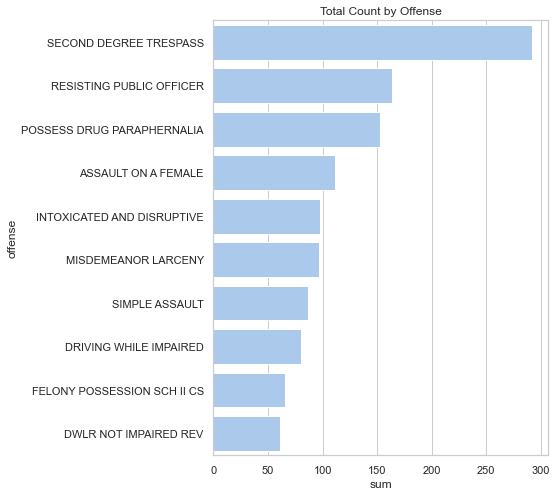

In [461]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 8))

sns.set_color_codes("pastel")
sns.barplot(x="sum", y="offense", data=cluster0_arrest_bar[0:10], label = "Total", color = "b")
plt.title( "Total Count by Offense")

Text(0.5, 1.0, 'Total Count by Venue Category')

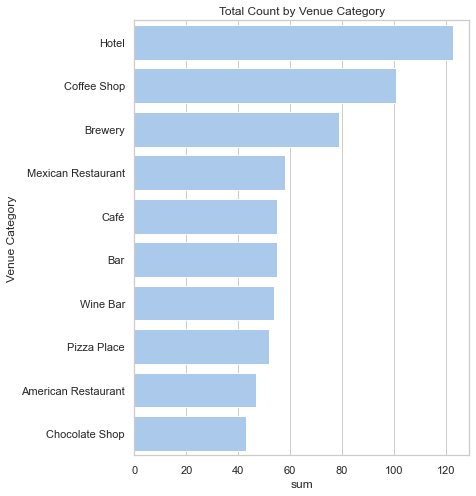

In [468]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 8))

sns.set_color_codes("pastel")
sns.barplot(x="sum", y="Venue Category", data=cluster0_venue_bar[0:10], label = "Total", color = "b")
plt.title( "Total Count by Venue Category")

A starting place for a marketing campaign would be to target Hotels and restaurants in Cluster 0.  Restaurants and bars are also the top venues in this area.  We will report back the findings and discuss with the Security Firm how they would like to target these businesses and what services they can provide.